We've looked a lot at different dither functions, but mostly at the end of the 10-year survey. It might be a good idea to check the time evolution of the co-added depth power spectrum.  

In [1]:
%matplotlib inline
import numpy as np
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils
import healpy as hp

In [2]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
propids, propTags = opsdb.fetchPropInfo()
wfdWhere = utils.createSQLWhere('WFD', propTags)
outDir = 'null'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
nside = 128


In [4]:
class HexDither_small(stackers.HexDitherFieldVisitStacker):
    """
    Same as HexDitherFieldVisitStacker, but change the order of the offsets (small offsets first, large last)
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_small, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_small', 'dec_small']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_small, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)
        print 'Doing small dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_small'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_small'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_small'], simData['dec_small'] = \
          stackers.wrapRADec(simData['ra_small'], simData['dec_small'])
        return simData


In [5]:
class HexDither_big(stackers.HexDitherFieldVisitStacker):
    """
    Same as HexDitherFieldVisitStacker, but change the order of the offsets (large offsets first, small last)
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_big, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_big', 'dec_big']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_big, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)[::-1]
        print 'Doing big dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_big'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_big'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_big'], simData['dec_big'] = \
          stackers.wrapRADec(simData['ra_big'], simData['dec_big'])
        return simData

In [6]:
bundleList = []
plotFuncs = [plots.TwoDMap()]
survey_length = 10.  # Years
sql = 'filter = "r" and night < %f and ' % (365.25*survey_length) + wfdWhere
step_size = 20. # Days
bins = np.arange(0,365.25*survey_length+step_size,step_size)

slicer =  slicers.HealpixSlicer(nside=nside, lonCol='hexDitherFieldNightRa', latCol='hexDitherFieldNightDec')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_defaultsteps')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs))

slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_small', latCol='dec_small')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_small')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs))

#stacker = HexDitherNightStacker_bigOffFirst(reverse=True)
#slicer = slicers.HealpixSlicer(nside=nside, lonCol='randomDitherFieldNightRa', latCol='randomDitherFieldNightDec')
slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_big', latCol='dec_big')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_bigsteps1st')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql,  plotFuncs=plotFuncs))

# Let's do one with no dither so it's easy to grab regions to mask
slicer = slicers.HealpixSlicer(nside=nside, lonCol='fieldRA', latCol='fieldDec')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='m5_nodither')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [7]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with constraint filter = "r" and night < 3652.500000 and propID = 54
Found 456557 visits
Running:  ['opsim_M5_small_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Doing small dithers
Completed metric generation.
Running:  ['opsim_m5_nodither_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Completed metric generation.
Running:  ['opsim_M5_bigsteps1st_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Doing big dithers
Completed metric generation.
Running:  ['opsim_M5_defaultsteps_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter = "r" and night < 3652.500000 and propID = 54 sqlconstraint now.
Plotting complete.


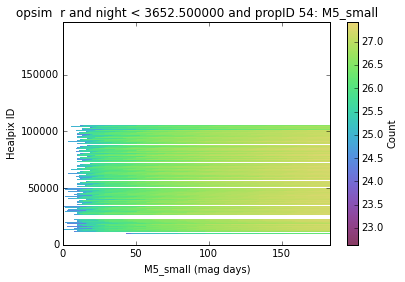

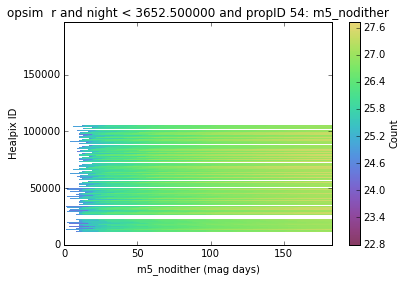

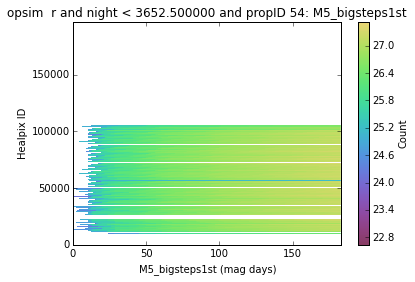

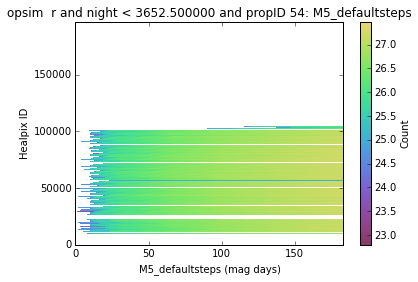

In [8]:
bg.plotAll(closefigs=False)

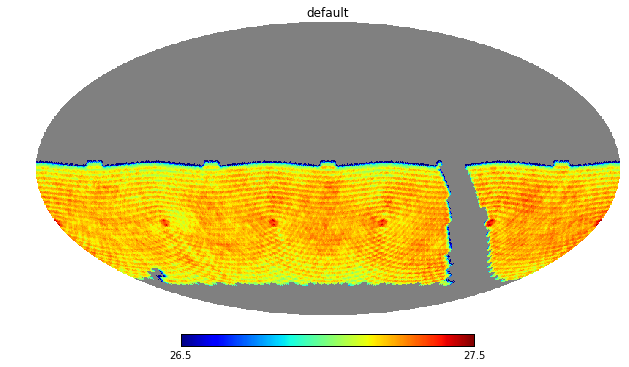

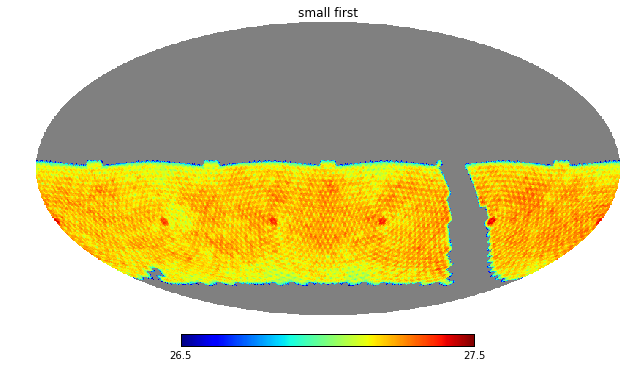

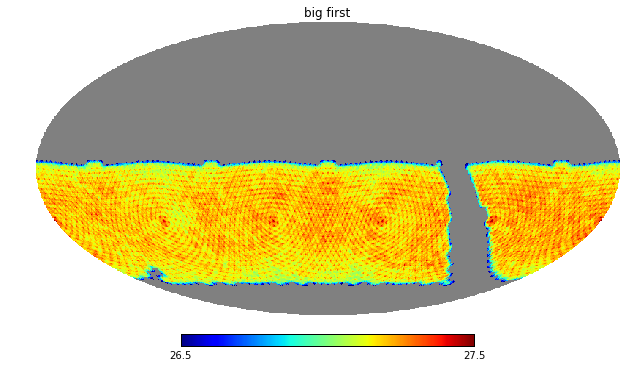

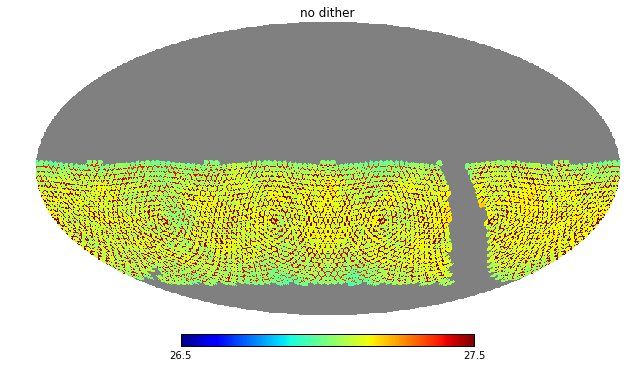

In [14]:
mask = np.where(bundleList[-1].metricValues.mask == True)
for bundle in bundleList:
    bundle.metricValues.mask[mask] = True

magMin = 26.5
magMax=27.5
hp.mollview(bundleList[0].metricValues[:,-1], title='default', min=magMin, max=magMax)
hp.mollview(bundleList[1].metricValues[:,-1], title='small first', min=magMin, max=magMax)
hp.mollview(bundleList[2].metricValues[:,-1], title='big first', min=magMin, max=magMax)
hp.mollview(bundleList[3].metricValues[:,-1], title='no dither', min=magMin, max=magMax)


In [10]:
# ok, now to loop over each bundle and each bin in the metric values and find the peak of the power spectrum.